# Demonstration of the evomap Package

Replication notebook for the paper

Matthe, Maximilian (2023), "evomap: A Python Package for Dynamic Mapping". 

Python environment: evomap-package

ToDo List
- Shepard Diagram --> CHeck if order in isotonic regression is really correct? (for shepard diagram AND mds code)

# Setup

First, create path variabels for each subfolder and load the essential packages.

In [115]:
import pandas as pd
import numpy as np
import os

PATH_HOME = os.path.dirname(os.getcwd()) # parent folder
PATH_OUT = os.path.join(PATH_HOME, 'gen') # output folder

title_fontdict_large = {'size': 14, 'family': 'Arial'}
title_fontdict = {'size': 12, 'family': 'Arial'}
label_fontdict = {'size': 10, 'family': 'Arial'}

np.random.seed(123)

## TEST: GET TNIC DATA

In [116]:
# Create a path variable to the data directory
PATH_DATA = os.path.join(PATH_HOME, 'data')

# Read the file tnic2_data_merged.csv from there
data = pd.read_csv(os.path.join(PATH_DATA, 'tnic2_data_merged.csv'))

In [117]:
# select the following columns from this dataframe: year, score, name1, same2, mkvalt1, mkvalt2, sic1, sic2
data = data[['year', 'score', 'name1', 'name2', 'mkvalt1', 'mkvalt2', 'sic1', 'sic2']]
data = data.dropna()
data.sic1 = data.sic1.astype(int).astype(str).map(lambda x: x[:2])
data.sic2 = data.sic2.astype(int).astype(str).map(lambda x: x[:2])
# Rename the two columns mkvalt1 and mkvalt2 to size1 and size2
data = data.rename(columns={'mkvalt1': 'size1', 'mkvalt2': 'size2'})
data['size1'] = data['size1'].map(np.sqrt)
data['size2'] = data['size2'].map(np.sqrt)
data.head()

,year,score,name1,name2,size1,size2,sic1,sic2
0,1998,0.0035,AAR CORP,AIR T INC,23.254564,3.165932,50,45
1,1999,0.0229,AAR CORP,AIR T INC,19.306783,3.096773,50,45
2,2000,0.0312,AAR CORP,AIR T INC,19.419526,3.289377,50,45
3,2001,0.0483,AAR CORP,AIR T INC,19.094313,3.087718,50,45
4,2002,0.0568,AAR CORP,AIR T INC,11.972030,1.959806,50,45


In [118]:
data.query('name1 == "HP INC"')

,year,score,name1,name2,size1,size2,sic1,sic2
192079,2004,0.0134,HP INC,AVX CORP,233.055319,46.029325,35,36
192080,2004,0.0189,HP INC,SKYWORKS SOLUTIONS INC,233.055319,38.457688,35,36
192081,2007,0.0033,HP INC,SKYWORKS SOLUTIONS INC,365.129593,38.162194,35,36
192082,1999,0.0009,HP INC,AMERICAN SOFTWARE -CL A,272.995353,13.031308,35,73
192083,2000,0.0290,HP INC,AMERICAN SOFTWARE -CL A,300.915284,5.786634,35,73
...,...,...,...,...,...,...,...,...
192699,2017,0.0061,HP INC,COGNIZANT TECH SOLUTIONS,188.542963,204.352049,35,73
192700,1998,0.0199,HP INC,ECHELON CORP,247.341931,11.229609,35,35
192701,1999,0.0472,HP INC,ECHELON CORP,272.995353,25.500147,35,35
192702,2015,0.0156,HP INC,ECHELON CORP,220.518172,4.990615,35,35


# Section 1: Quick Illustration

This first section provides a quick illustration of how EvoMap can be applied using the evomap package. The section also highlights the differences between applying EvoMap vs. applying existent static mapping methods.

## Loading the Data

For this illustration, we use a small sample from the TNIC data available through the dataset submodule

In [119]:
#from evomap.datasets import load_tnic_sample_small
#data = load_tnic_sample_small()
#labels = data[data['sic1'].map(lambda x: x.startswith("36"))].groupby('name1').agg({'year':'nunique'}).query('year == 20').index.values
#labels = [label for label in labels if not label == "CALAMP CORP"] # Exclude calamp corp, as it has no connections to the others in one period
#labels
#data.head()

The sample is organized as an edgelist where each observation corresponds to a single firm x firm pair.

For this simple example, we select only a few firms, drop all other firms, and remove the gvkey identifier. 

#TODO: Save either the full data (including all 10 firms), or the smaller sample including 8 firms as another dataset in the dataset module!

In [120]:
labels = np.array([
    'ADOBE INC', 'MICROSOFT CORP', 'CITRIX SYSTEMS INC', 'HP INC',
       'WESTERN DIGITAL CORP', 'NETAPP INC', 'SONIC FOUNDRY INC',
       'NORTONLIFELOCK INC', 'NUANCE COMMUNICATIONS INC', 'TIVO CORP',
       'MICROSTRATEGY INC', 'FALCONSTOR SOFTWARE INC'])

selected_names = np.array([
	'US CELLULAR CORP', 
	'AT&T INC', 
#	'COMCAST CORP', 
	'MICROSOFT CORP', 
	'WESTERN DIGITAL CORP',
#	'HP INC', 
	'ORACLE CORP', 
	'EBAY INC', 
	'INTUIT INC', 
	'APPLE INC'])


data = data.query('name1 in @selected_names').query('name2 in @selected_names')
data = data[['year', 'name1', 'name2', 'score', 'sic1', 'sic2', 'size1', 'size2']]
data = data.sort_values(['year', 'name1'])
data.index = range(len(data))
periods = data.year.unique()
n_periods = len(periods)
data.head()

,year,name1,name2,score,sic1,sic2,size1,size2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.792988,32.294908
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.792988,517.384045
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.792988,188.441005
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.142356,57.620292
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.544590,517.384045


In [121]:
# Check if the panel is balanced: If not, drop some or use inclusio nvectors
data.groupby('name1').agg({'year':'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICROSOFT CORP,20
ORACLE CORP,20
US CELLULAR CORP,20
WESTERN DIGITAL CORP,20


In [122]:
table_1 = pd.concat([data.head(), data.tail()], axis = 0)
table_1.to_excel(os.path.join(PATH_OUT, "table2-data-overview.xlsx"))

Next, transform the edgelist into a sequence of similarity matrices

In [123]:
from evomap.preprocessing import edgelist2matrices
S_t, labels_t = edgelist2matrices(
    data, 
    score_var = 'score', 
    id_var_i = 'name1', 
    id_var_j ='name2', 
    time_var = 'year')

The result is a sequence of matrices and a sequence of labels. As the sample is balanced, all labels remain the same over time in this example. Therefore, we simply use the first list of labels in what follows. 

In [124]:
S_t[0][:5, :5].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.06],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.03],
       [0.  , 0.  , 0.09, 0.  , 0.05],
       [0.06, 0.  , 0.03, 0.05, 0.  ]])

Next, transform each similarity matrix into a dissimilarity matrix

In [125]:
from evomap.preprocessing import sim2diss
D_t = []
for S in S_t:
    D_t.append(sim2diss(S, transformation = 'mirror'))

Preview a single dissimilarity matrix

In [126]:
D_t[0][:5, :5]

array([[0.    , 1.    , 1.    , 1.    , 0.9399],
       [1.    , 0.    , 1.    , 1.    , 1.    ],
       [1.    , 1.    , 0.    , 0.9147, 0.9719],
       [1.    , 1.    , 0.9147, 0.    , 0.9464],
       [0.9399, 1.    , 0.9719, 0.9464, 0.    ]])

## Static Mapping via MDS

To map this similarity matrix via MDS, we first transform it into dissimilarities using the sim2diss function from the preprocessing submodule

In [127]:
D = D_t[0]    
labels = labels_t[0]
n_samples = len(labels)

Then, we run ordinal MDS, initialized via Classical Scaling.

In [128]:
from evomap.mapping import MDS
X = MDS(init = 'cmds', mds_type = 'ordinal').fit_transform(D)

Plot the results using the draw_map function from the printer submodule

In [129]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map

fig, ax = plt.subplots(1,2, figsize = (12,6))
draw_map(
    X, 
    label = labels, 
    show_axes = True, 
    axes_at_origin = False, 
    show_grid = False, 
    title = 'A: Non-Metric MDS Map \n', ax = ax[0])

Next, add the Shepard diagram

In [130]:
from evomap.printer import draw_shepard_diagram
    
draw_shepard_diagram(X,D, ax = ax[1])
ax[1].set_title('B: Shepard Diagramm \n', fontdict= title_fontdict_large)
ax[1].legend(['Observed dissimilarities', 'Transformed dissimilariites'], loc = 4, prop = label_fontdict)

and display the resulting Figure

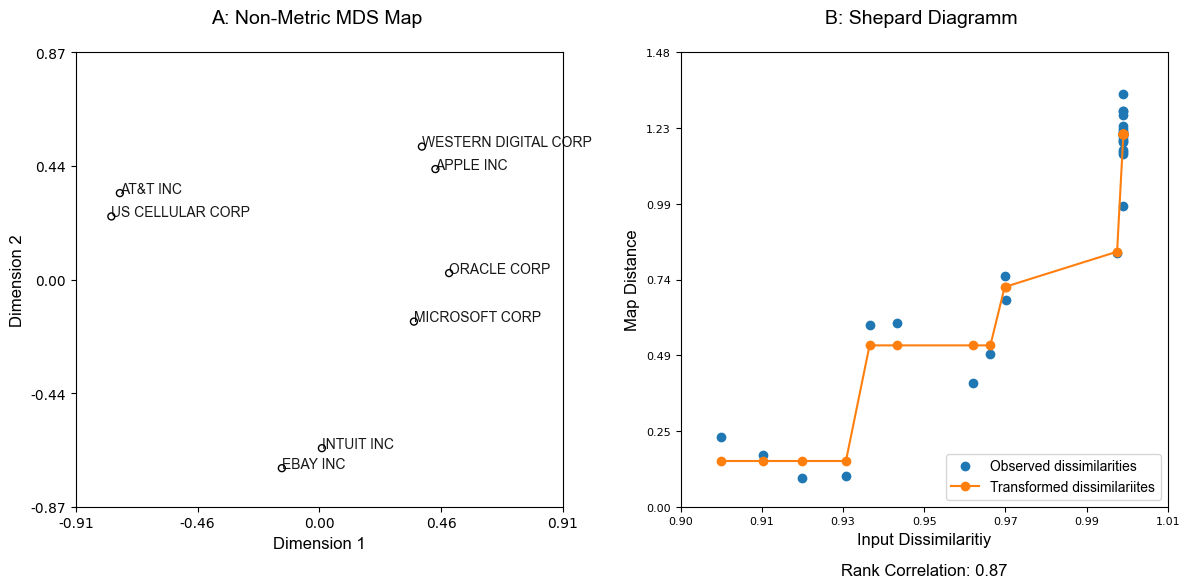

In [131]:
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_statc.PNG'), dpi = 300)
fig

## Dynamic Mapping via EvoMap

First, create fixed starting configurations to initialize the optimization routine and ensure reproducibility. 

In [132]:
from evomap.mapping import CMDS
cmds_t = []
for t in range(n_periods):
    cmds = CMDS().fit_transform(D_t[t])
    cmds_t.append(cmds)

Then, initialize the model class, and fit configurations to the data.  

To create a benchmark of independent mapping, we first use EvoMDS with alpha = 0.

In [ ]:
from evomap.mapping import EvoMDS
evomds_indep = EvoMDS(alpha = 0, verbose = 2, init = cmds_t, mds_type = 'ordinal')
X_t_indep = evomds_indep.fit_transform(D_t)

Display the first and last snapshot:

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
draw_map(X_t_indep[0], label = labels, ax = ax[0])
draw_map(X_t_indep[-1], label = labels, ax = ax[1])
fig

As a second benchmark, align the independently created configurations using Procrustes.

In [ ]:
from evomap.transform import align_maps
X_t_indep_aligned = align_maps(X_t_indep, X_t_indep[0])

Finally, run EvoMap with MDS setting alpha to a positive value:

In [ ]:
from evomap.mapping import EvoMDS

# Interval with 1.15
evomds = EvoMDS(alpha = 1.15, mds_type = 'interval', init = cmds_t, verbose=2)
X_t = evomds.fit_transform(D_t) 

 Show all results side by side:
 
 #TODO: Check why label sizes look so different when not setting them manually

In [ ]:
from evomap.printer import draw_trajectories
fig, ax = plt.subplots(1,3,figsize = (18,6))
draw_trajectories(X_t_indep, show_axes= True, labels = data.name1.unique(), period_labels= periods, ax = ax[0])
draw_trajectories(X_t_indep_aligned, labels = data.name1.unique(), period_labels= periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t, labels = data.name1.unique(), period_labels= periods, show_axes = True, ax = ax[2])
ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_title('Solution A: \nIndependent Application of Non-Metric MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nEx-Post Alignenment of Non-Metric MDS\n', fontdict = title_fontdict)
ax[2].set_title('Solution C: \nEvoMap Solution for Non-Metric MDS\n', fontdict = title_fontdict)

ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[2].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[2].set_ylabel("Dimension 2", fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_dynamic.PNG'), dpi = 300)
fig

## Section 2: Step by Step Instructions

#TODO: Outline

bare minimum, only use the alpha argument. Without that, simply independent mapping

In [ ]:
evomds = EvoMDS()
X_t = evomds.fit_transform(D_t) 

Output is a list of arrays shape (n_samples, n_dims)

In [ ]:
print(type(X_t))

In [ ]:
print(len(X_t))

In [ ]:
print(X_t[0].round(2))

Naturally, the resultant configurations will not be aligned. Instead, they correspond to the results of independently applying MDS at each point in time. 

Better results: Set alpha to higher levels. In addition, we specify the type of MDS method used (here: interval MDS), and set a higher level of verbosity to obtain more diagnostics. 

In [ ]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = 1.15, 
    mds_type = 'interval')

X_t = evomds.fit_transform(D_t) 

First snapshot

In [ ]:
draw_map(X_t[0], label = labels, title = 'First snapshot')

Last snapshot

In [ ]:
draw_map(X_t[-1], label = labels, show_axes = True)

Side by side comparison

In [ ]:
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2,figsize = (12,6))

draw_map(X_t[0], label = labels, ax = ax[0])
draw_map(X_t[-1], label = labels, ax = ax[1])
ax[0].set_title('A: EvoMap Snapshot in {0}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: EvoMap Snapshot in {0}'.format(periods[-1]), fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_evomds_snapshots.PNG'), dpi = 300)
fig

Result: Much better alignment! 

## Fixing the starting configuration

Thus far, initialized randomly. If one of the cell is run again, output will differ. To change that: Set a fixed init. 

One way to fix the starting configuration is to manually calculate random numbers: 

In [ ]:
init_t = []
for t in range(n_periods):
    init = np.random.normal(0,.1,(n_samples, 2))
    init_t.append(init)

In [ ]:
evomds_init = EvoMDS(alpha = 1.15, mds_type = 'interval', init = init_t)
X_t_init = evomds_init.fit_transform(D_t) 

In [ ]:
print("Final cost when initialized randomlly: {0:.3f}".format(evomds_init.cost_))

Another useful approach, especially for MDS variants, is to use the classical scaling solution as a starting point for the optimization:

In [ ]:
from evomap.mapping import CMDS
cmds_t = []
for t in range(n_periods):
    cmds = CMDS().fit_transform(D_t[t])
    cmds_t.append(cmds)

In [ ]:
evomds_cmds = EvoMDS(alpha = 1.15, mds_type = 'interval', init = cmds_t)
X_t_cmds = evomds_cmds.fit_transform(D_t) 

In [ ]:
evomds_init.cost_static_

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
draw_map(X_t_init[0], label = labels, ax = ax[0])
draw_map(X_t_cmds[0], label = labels, ax = ax[1])
ax[0].set_xlabel(evomds_init.costs_static_[0])
ax[1].set_xlabel(evomds_cmds.costs_static_[0])
fig

In [ ]:
X_t = X_t_cmds

### Verbosity

In [ ]:
EvoMDS(
    alpha = 1.15, 
    mds_type = 'interval', 
    init = cmds_t,
    verbose = 0).fit(D_t)

In [ ]:
EvoMDS(
    alpha = 1.15, 
    mds_type = 'interval', 
    init = cmds_t,
    verbose = 1).fit(D_t)

In [ ]:
EvoMDS(
    alpha = 1.15, 
    mds_type = 'interval', 
    init = cmds_t,
    verbose = 2).fit(D_t)

## Exploration

#### Static Exploration via Draw Map

First, store some additional to augment the maps with.

SIC codes are categorical industry codes:

In [ ]:
sic_codes = []
for firm in labels:
    sic_codes.append(data.query('name1 == @firm').sic1.unique()[0])
sic_codes

Size is a variable proportional to market value:

In [ ]:
sizes = []
for firm in labels:
    sizes.append(data.query('name1 == @firm').size1.unique()[0])
sizes

Such variables can be added to the map via the 'c' and 'size' arguments:

In [ ]:
sic = data.sic1

fig, ax = plt.subplots(2,2,figsize = (12,10))
draw_map(X_t[0], title = periods[0], ax = ax[0,0])
draw_map(X_t[0], label = labels, title = periods[0], ax = ax[0,1])
draw_map(X_t[0], label = labels, color = sic_codes, show_legend = True, title = periods[0], ax = ax[1,0])
draw_map(X_t[0], label = labels, color = sic_codes, size = sizes, title = periods[0], ax = ax[1,1])
fig.tight_layout()

ax[1,0].legend(title = 'SIC Code', loc = 'lower left')
ax[1,1].legend(title = 'SIC Code', loc = 'lower left')

fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_examples.PNG'), dpi = 300)
fig

### Draw Map Sequence

In [ ]:
from evomap.printer import draw_map_sequence
fig = draw_map_sequence(X_t[:3], 
                  color = sic_codes,
                  label = labels, 
                  size = sizes,
                  fig_size = (15,5),
                  n_cols=3,
                  time_labels = periods[:4])

In [ ]:
from evomap.printer import draw_map_sequence
fig = draw_map_sequence(X_t[:3], 
                  color = sic_codes,
                  label = labels, 
                  size = sizes,
                  fig_size = (15,5),
                  n_cols=3,
                  time_labels = periods[:4])

fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.PNG'), dpi = 300)
fig

### Advanced: Adjust Figure Layout

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
draw_map(X, label = labels, show_axes = True, axes_at_origin = False, show_grid = False, ax = ax[0,0])
draw_map(X, label = labels, show_axes = True, axes_at_origin = False, show_grid = True, ax = ax[0,1])
draw_map(X, label = labels, show_axes = False, axes_at_origin = False, show_grid = False, ax = ax[1,0])
draw_map(X, label = labels, show_axes = True, axes_at_origin = True, show_grid = False, ax = ax[1,1])
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_options.PNG'), dpi = 300)
fig

## Drawing Dynamic Maps

### Dynamic Map

In [ ]:
sic_codes_t = []
sizes_t = []
for t in range(n_periods):
    # get data in period t
    data_this = data.query('year == @periods[@t]')
    # get all sic codes in period t
    sic_this = []
    for firm in labels:
        sic_this.append(data_this.query('name1 == @firm').sic1.unique()[0])

    sic_codes_t.append(np.array(sic_this))    

    sizes_this = []
    for firm in labels:
        sizes_this.append(data_this.query('name1 == @firm').size1.unique()[0])
    
    sizes_t.append(np.array(sizes_this))


In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 title = 'A: Dynamic Map',
                 ax = ax[0])

### Draw Trajectories

In [ ]:
draw_trajectories(X_t, 
                  labels = labels, 
                  period_labels = periods, 
                  title = "B: Trajectories", 
                  ax = ax[1])

In [ ]:
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_dynamic_map_and_trajectories.PNG'), dpi = 300)
fig

## Evaluation

In [ ]:
evomds_indep = EvoMDS(alpha = 0, verbose = 2, mds_type= 'ordinal').fit(D_t)

In [ ]:
evomds_indep.cost_static_avg_

In [ ]:
evomds.cost_static_avg_

In [ ]:
from evomap.metrics import *

# Use the three lists X_t, X_t_indep, and X_t_indep_aligned and compute the following metrics for each of them: misalign_score, align_score, and avg_adjusted_hitrate_score. Store the results in a dataframe

misalign_score_t = []
align_score_t = []
persistence_score_t = []
avg_hitrate_score_t = []
avg_adjusted_hitrate_score_t = []

for i, X in enumerate([X_t, X_t_indep, X_t_indep_aligned]):
    misalign_score_t.append(misalign_score(X))
    align_score_t.append(align_score(X))
    persistence_score_t.append(persistence_score(X))
    avg_hitrate_score_t.append(avg_hitrate_score(X, D_t, input_format='dissimilarity', n_neighbors=5))
  
    avg_adjusted_hitrate_score_t.append(avg_adjusted_hitrate_score(X, D_t, input_format='dissimilarity', n_neighbors=5))

metrics = pd.DataFrame({'misalign_score': misalign_score_t, 
                        'align_score': align_score_t,
                        'hitrate_score': avg_hitrate_score_t,
                        'adjusted_hitrate_score': avg_adjusted_hitrate_score_t,},
                          index = ['EvoMDS', 'Independent MDS', 'Independent MDS + Alignment'])

metrics['average_stress'] = [evomds.cost_static_avg_, evomds_indep.cost_static_avg_, evomds_indep.cost_static_avg_]

# sort metrics such that the order is Independent MDS, Independent MDS + Alignment, EvoMDS
metrics = metrics.reindex(['Independent MDS', 'Independent MDS + Alignment', 'EvoMDS'])
metrics.round(4)

In [ ]:
metrics.round(4).to_excel(os.path.join(PATH_OUT, 'sect4_metrics.xlsx'))

## Hyperparameter Tuning

### Use the Grid Search

First, define the parameter space across which the grid search shall be completed

In [ ]:
param_grid = {
    'alpha': np.linspace(0.25, 2, 20), 
    'p': [1, 2]}

Next, define the metrics on which each parameter combination is to be evaluated

In [ ]:
from evomap.metrics import misalign_score, persistence_score, avg_hitrate_score

metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

In [ ]:
model = EvoMDS(init = cmds_t, mds_type = 'interval', verbose = 1)

df_grid_results = model.grid_search(
    Xs = D_t, 
    param_grid = param_grid, 
    eval_functions =  metrics,
    eval_labels = metric_labels, 
    kwargs = {"input_format" : 'dissimilarity'})

In [ ]:
df_grid_results.tail()

In [ ]:
# Create a grouped line plot based on htis dttaframe
df_grid_results.groupby(['alpha', 'p']).Misalignment.mean().unstack().plot(title = 'Misalignment')
df_grid_results.groupby(['alpha', 'p']).cost_static_avg.mean().unstack().plot(title = 'Average Stress')

### Results across Hyperparameters

In [ ]:
X_t_low_alpha = EvoMDS(alpha = 0.5, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_low_alpha = align_maps(X_t_low_alpha, X_t[0])

X_t_mid_alpha = EvoMDS(alpha = 1, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_mid_alpha = align_maps(X_t_mid_alpha, X_t[0])

X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_high_alpha = align_maps(X_t_high_alpha, X_t[0])

from evomap.printer import draw_trajectories
fig, ax = plt.subplots(1,3,figsize = (17,6))
draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_title('Solution A: \nLow Alpha\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nMedium Alpha\n', fontdict = title_fontdict)
ax[2].set_title('Solution C: \nHigh Alpha\n', fontdict = title_fontdict)

ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[2].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[2].set_ylabel("Dimension 2", fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_alpha.PNG'), dpi = 300)
fig

### Results across Hyperparameter p

In [ ]:
X_t_p1 = EvoMDS(alpha = 1.1, p = 1, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_p2 = EvoMDS(alpha = 1.15, p = 2, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_p3 = EvoMDS(alpha = 3, p = 3, mds_type = 'interval', init = cmds_t).fit_transform(D_t)

fig, ax = plt.subplots(1,3,figsize = (17,6))
draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_title('Solution A: \np = 1\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \np = 2\n', fontdict = title_fontdict)
ax[2].set_title('Solution C: \np = 3\n', fontdict = title_fontdict)

ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[2].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[2].set_ylabel("Dimension 2", fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_p.PNG'), dpi = 300)
fig

### Results across MDS Types

In [ ]:
X_t_interval = EvoMDS(alpha = 1.1, p = 1, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_ordinal = EvoMDS(alpha = 1.5, p = 1, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

fig, ax = plt.subplots(1,2,figsize = (13,6))
draw_trajectories(X_t_interval, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_ordinal, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_title('Solution A: \nInterval MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nOrdinal MDS\n', fontdict = title_fontdict)

ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_mds_types.PNG'), dpi = 300)
fig

## Rotate and Align Map Sequences

In [ ]:
X_t_mid_alpha = EvoMDS(alpha = 1, mds_type = 'interval', init = cmds_t).fit_transform(D_t)

X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_high_alpha_rotated = align_maps(X_t_high_alpha, X_t[0])

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (12,12))
draw_trajectories(X_t_mid_alpha, labels = labels, ax = ax[0,0])
draw_trajectories(X_t_high_alpha, labels = labels, ax = ax[0,1])
draw_trajectories(X_t_mid_alpha, labels = labels, ax = ax[1,0])
draw_trajectories(X_t_high_alpha_rotated, labels = labels, ax = ax[1,1])
fig

## EvoTSNE

[EvoTSNE] Initialization 1/1
[EvoTSNE] Gradient descent with Momentum: 0.5
[EvoTSNE] Iteration 50 -- Cost: 146.58 -- Gradient Norm: 0.0025
[EvoTSNE] Iteration 78: gradient norm vanished.
[EvoTSNE] Gradient descent with Momentum: 0.8
[EvoTSNE] Iteration 251: gradient norm vanished.


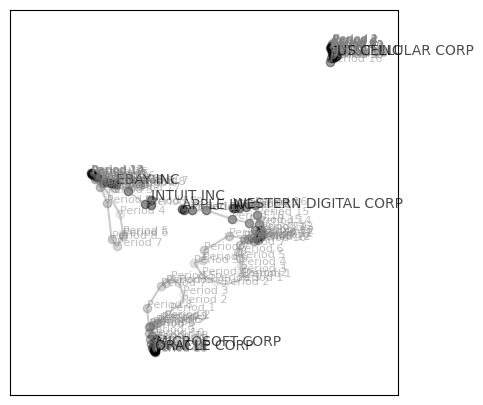

In [189]:
from evomap.mapping import EvoTSNE

X_t_tsne = EvoTSNE(alpha = .25, p = 1, input_type = 'distance', perplexity = 5, eta = .1, verbose = 2).fit_transform(D_t)
draw_trajectories(X_t, labels = labels)

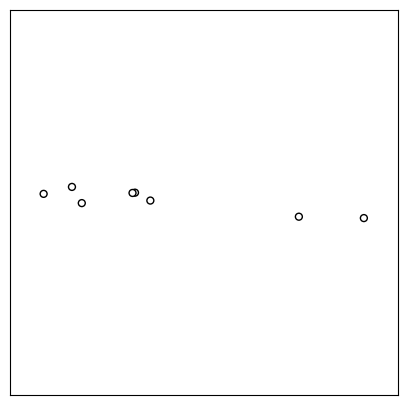

In [191]:
draw_map(X_t_tsne[0])

## EvoSammon

In [176]:
from evomap.mapping import EvoSammon

#D_t = normalize_diss_mats(D_t)

X_t_sammon = EvoSammon(alpha = 15, p = 1, step_size = .01, verbose = 2).fit_transform(D_t_inv)

[EvoSammon] Initialization 1/1
[EvoSammon] Running Gradient Descent with Backtracking via Halving
[EvoSammon] Iteration 50 -- Cost: 21.73 -- Gradient Norm: 0.0081
[EvoSammon] Iteration 100 -- Cost: 19.00 -- Gradient Norm: 0.0028
[EvoSammon] Iteration 150 -- Cost: 17.99 -- Gradient Norm: 0.0038
[EvoSammon] Iteration 200 -- Cost: 17.38 -- Gradient Norm: 0.0027
[EvoSammon] Iteration 250 -- Cost: 17.02 -- Gradient Norm: 0.0023
[EvoSammon] Iteration 300 -- Cost: 16.74 -- Gradient Norm: 0.0020
[EvoSammon] Iteration 350 -- Cost: 16.53 -- Gradient Norm: 0.0018
[EvoSammon] Iteration 400 -- Cost: 16.37 -- Gradient Norm: 0.0016
[EvoSammon] Iteration 450 -- Cost: 16.24 -- Gradient Norm: 0.0016
[EvoSammon] Iteration 500 -- Cost: 16.14 -- Gradient Norm: 0.0014
[EvoSammon] Iteration 550 -- Cost: 16.06 -- Gradient Norm: 0.0013
[EvoSammon] Iteration 600 -- Cost: 16.00 -- Gradient Norm: 0.0013
[EvoSammon] Iteration 650 -- Cost: 15.96 -- Gradient Norm: 0.0013
[EvoSammon] Iteration 700 -- Cost: 15.93 -- G

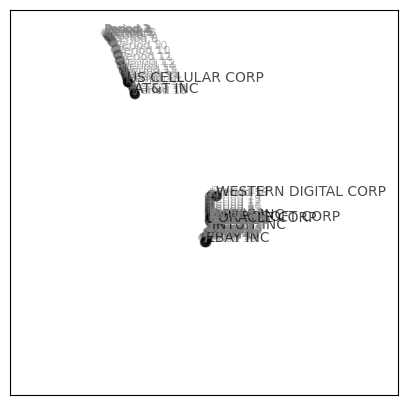

In [177]:
draw_trajectories(X_t_sammon, labels = labels)

In [100]:
avg_hitrate_score(X_t_sammon, D_t, input_format='dissimilarity', n_neighbors=5)

0.6812500000000001

# THE END

For further examples, using a larger dataset, see https://evomap.readthedocs.io/en/latest/dynamic%20mapping.html